In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import sys
import re, string
import nltk, spacy, gensim
from scipy.stats.mstats import gmean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, fbeta_score 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion, Pipeline 


from numpy import dot
from numpy.linalg import norm
import pickle

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
def load_data(data_splits):
    """
    Function that combines the DataFrame for training, validation, and test.
    """
    path = "dataset/archive/disaster_response_messages_{}.csv"
    dfs = []
    for data_split in data_splits:
        file_path = path.format(data_split)
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs) #combine files for each split

In [4]:
def data_cleaning(data_df):
    """
    Function that cleans the data.
    """    
    data_df = data_df.drop_duplicates()
    return data_df 

In [5]:
def save_to_database(data_df,db_name):
    """
    Save data to database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Write dataframe to database
    data_df.to_sql('data_df',engine,if_exists='replace')
    pass 

In [6]:
def load_from_database(db_name):
    """
    Load data from database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Read dataframe from database
    data_df = pd.read_sql_table('data_df',engine)
    data_df = data_df.dropna(subset=["message"])
    X = data_df['message'].fillna(value='')
    C = data_df.iloc[:,4:]
    message_class = C.columns
    return X, C, message_class

In [7]:
def document_cleaning(data_df):
    """
    Function that cleans the document.
    """    

    data = data_df.values.tolist()                            # convert data to list
    data = [re.sub(r'\S*@\S*\s?', '', item) for item in data] # Remove email addresses
    data = [re.sub('[%s]' % re.escape(string.punctuation), ' ', item) for item in data] # Remove punctuations
    data = [re.sub(r'\s+', ' ', item) for item in data]       # Remove characters that begin a new line
    data = [re.sub(r"\'", "", item) for item in data]         # Remove single quotes
    data = [re.sub(r'\w*\d\w*', ' ', item) for item in data]  # Remove numbers
    data = [re.sub(r' +', ' ', item) for item in data]# Remove extra spaces
    data = [item.lower() for item in data]                    # Make each document lower case
    
    return data

In [8]:
def tokenize_doc(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

### Load data from database

In [10]:
# Load data from database

database_name = 'disaster_response.db'
X, C, message_class = load_from_database(database_name)

# train test split
#X_train, X_test, y_train, y_test = train_test_split(X, C,test_size=.2, random_state=2018)

In [11]:
pprint(X[:1])

0    Weather update - a cold front from Cuba that c...
Name: message, dtype: object


In [12]:
pprint(message_class)

Index(['genre', 'related', 'PII', 'request', 'offer', 'aid_related',
       'medical_help', 'medical_products', 'search_and_rescue', 'security',
       'military', 'child_alone', 'water', 'food', 'shelter', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')


### Document Cleaning

In [13]:
# Document cleaning

# X = X[:100]
message_data = document_cleaning(X)
pprint(message_data[:1])

['weather update a cold front from cuba that could pass over haiti']


### Tokenize documents

In [14]:
message_words = list(tokenize_doc(message_data))
print(message_words[:2])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over']]


In [15]:
# Initialize spaCy ‘en_core_web_sm’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [16]:
def topic_prediction(text, nlp=nlp):
    global tokenize_doc
    global lemmatization
    text_doc2 = list(tokenize_doc(text))
    text_doc3 = lemmatization(text_doc2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    text_doc4 = vectorizer.transform(text_doc3)
    topic_probability_scores = model.transform(text_doc4)
    topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    infer_topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), -1]
    return infer_topic, topic, topic_probability_scores

In [17]:
def similar_corpus(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    dist = euclidean_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(dist)
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [18]:
def similar_corpus_cosine(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    #dist = cosine_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    dist = cosine_similarity(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(np.argsort(dist))
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [19]:
# Lemmatization for any choice to keep -  Noun, Adj, Verb, Adverb ['NOUN', 'ADJ', 'VERB', 'ADV']

message_lemmatized = lemmatization(message_words, allowed_postags=['NOUN', 'VERB'])

In [20]:
print(message_lemmatized[:3])

['weather update front pass', 'be hurricane be', 'look name']


In [21]:
print(message_words[:4])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over'], ['looking', 'for', 'someone', 'but', 'no', 'name'], ['un', 'reports', 'leogane', 'destroyed', 'only', 'hospital', 'st', 'croix', 'functioning', 'needs', 'supplies', 'desperately']]


In [22]:
print(message_lemmatized[:4])

['weather update front pass', 'be hurricane be', 'look name', 'report leogane destroy hospital functioning need supply']


In [23]:
# Document word Matrix
# Document word Matrix
# Words that have occured in less than 10 documents (min_df) are cut off
# Words that have occured in more than 50% of the documents (max_df, None) are cut off
# At least 3 characters in each word
# Max number of unique words = 50000

vectorizer = CountVectorizer(analyzer='word',min_df=10,max_df=0.5,stop_words='english',lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',max_features=50000)
message_vectorized = vectorizer.fit_transform(message_lemmatized)

In [26]:
# NMF Model

model = NMF(10) # 10 topics
output = model.fit_transform(message_vectorized)
print(model)  # Model attributes

/Users/amyphillip/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=10)


In [27]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [28]:
# Dominant topics (Create Document — Topic Matrix)

topic_names = ["Topic" + str(i) for i in range(model.n_components)] # column names
doc_names = ["Doc" + str(i) for i in range(len(message_data))]               # index names
# Document — Topic Matrix dataframe
document_topic_df = pd.DataFrame(np.round(output, 2), columns=topic_names, index=doc_names)
# Get dominant topic for each document
dominant_topics = np.argmax(document_topic_df.values, axis=1)
document_topic_df["dominant_topic"] = dominant_topics

document_topics_df = document_topic_df.head(15)
document_topics_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0
Doc1,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0
Doc2,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0
Doc3,0.01,0.0,0.01,0.00,0.0,0.11,0.00,0.03,0.01,0.00,5
Doc4,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.01,0.17,0.01,8
Doc5,0.00,0.0,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.05,9
Doc6,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0
Doc7,0.00,0.0,0.14,0.00,0.0,0.12,0.00,0.00,0.00,0.05,2
Doc8,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.16,9
Doc9,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.07,0.00,0.00,7


In [29]:
# Topic-Keyword Matrix

topic_keywords_df = pd.DataFrame(model.components_)
# Assign Column and Index
topic_keywords_df.columns = vectorizer.get_feature_names()
topic_keywords_df.index = topic_names
# View
topic_keywords_df.head()

,abandon,ability,absence,absorb,abuse,accelerate,accept,access,accident,accommodate,...,yard,year,yesterday,yield,yorker,youth,yuan,zimbabwe,zinc,zone
Topic0,0.022260,0.005606,0.054887,0.028458,0.0,0.000000,0.002184,0.033802,0.042286,0.000000,...,0.000000,1.128476,0.004543,0.073442,0.001984,0.000000,0.036435,0.000000,0.000000,0.000000
Topic1,0.007485,0.003567,0.000000,0.000021,0.0,0.000000,0.000000,0.001646,0.000000,0.000000,...,0.012813,0.054900,0.014008,0.000000,0.000000,0.011235,0.000000,0.004192,0.000000,0.001968
Topic2,0.018624,0.000000,0.003025,0.008517,0.0,0.000000,0.003920,0.118738,0.000000,0.000000,...,0.000000,0.000000,0.012788,0.003181,0.000000,0.000000,0.000000,0.013275,0.000000,0.027890
Topic3,0.000000,0.002197,0.009009,0.000000,0.0,0.007861,0.002168,0.013689,0.000000,0.000000,...,0.000000,0.025741,0.000000,0.002091,0.003313,0.000000,0.000000,0.006684,0.000000,0.032655
Topic4,0.005260,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.006842,0.006276,0.005867,...,0.009966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003328,0.053793


In [30]:
# Keyword-topic Matrix for top n words

keyword_topic_df = pd.DataFrame(model.components_).T
# Assign Column and Index
keyword_topic_df.index = vectorizer.get_feature_names()
keyword_topic_df.columns = topic_names
# View
keyword_topic_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
abandon,0.022260,0.007485,0.018624,0.000000,0.00526,0.000000,0.000000,0.016532,0.013806,0.004054
ability,0.005606,0.003567,0.000000,0.002197,0.00000,0.000000,0.005747,0.022622,0.025390,0.001772
absence,0.054887,0.000000,0.003025,0.009009,0.00000,0.000000,0.001092,0.015892,0.000000,0.000000
absorb,0.028458,0.000021,0.008517,0.000000,0.00000,0.000000,0.002058,0.000000,0.002018,0.000000
abuse,0.000000,0.000000,0.000000,0.000000,0.00000,0.000719,0.000000,0.022127,0.004218,0.001603


In [31]:
# Show top n keywords for each topic

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=model, n_words=15)

# Topic - Keywords Dataframe
topic_keywords_df = pd.DataFrame(topic_keywords)
topic_keywords_df.columns = ['Word '+str(i) for i in range(topic_keywords_df.shape[1])]
topic_keywords_df.index = ['Topic '+str(i) for i in range(topic_keywords_df.shape[0])]

#Keywords-topic
keywords_topic_df = pd.DataFrame(topic_keywords).T
keywords_topic_df.columns = ['Topic '+str(i) for i in range(keywords_topic_df.shape[1])]
keywords_topic_df.index = ['Word '+str(i) for i in range(keywords_topic_df.shape[0])]

keywords_topic_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Word 0,rain,help,water,food,people,need,earthquake,area,say,know
Word 1,flood,victim,supply,supply,kill,tent,http,provide,official,like
Word 2,cause,ask,drinking,tent,live,job,bit,include,government,thank
Word 3,region,house,sanitation,cook,die,thank,haiti,government,report,information
Word 4,area,live,river,distribution,leave,shelter,hit,health,day,want
Word 5,rainfall,don,tank,distribute,house,family,com,work,make,message
Word 6,affect,thank,facility,baby,make,sleep,magnitude,relief,force,send
Word 7,monsoon,come,drink,clothing,come,information,information,country,state,school
Word 8,flooding,family,disease,eat,injure,aid,news,support,use,country
Word 9,damage,want,kit,item,lot,street,victim,family,country,let


In [32]:
# Message-Topic-Matrix
document_topic_df['message'] = message_data
document_topic_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,message
Doc0,0.01,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0,weather update a cold front from cuba that cou...
Doc1,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0,is the hurricane over or is it not over
Doc2,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0,looking for someone but no name
Doc3,0.01,0.0,0.01,0.0,0.0,0.11,0.0,0.03,0.01,0.00,5,un reports leogane destroyed only hospital st ...
Doc4,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.17,0.01,8,says west side of haiti rest of the country to...
...,...,...,...,...,...,...,...,...,...,...,...,...
Doc26211,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.03,0.01,0.00,7,the training demonstrated how to enhance micro...
Doc26212,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.03,0.00,0.01,7,a suitable candidate has been selected and och...
Doc26213,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.02,0.00,0.00,7,proshika operating in cox s bazar municipality...
Doc26214,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.02,0.01,0.01,7,some women protesting against the conduct of t...


## Topic interpretation

* ### Topic0

In [33]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic0', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic1

In [34]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic1', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

we are cooped up all day here tarpaulin sheets will also be distributed to cover temporary shelters and make them fully waterproofed armenia s continued refusal to close the nuclear power plant which is considered to be structurally unsafe the power plant lies on an earthquake prone fault line might aggravate its relations with the european commission the state council also put emphasis on the efforts to restore hydropower facilities saying priority should be given to the reconstruction and repair of reservoirs dams rural water supply systems irrigation hydrology and water resources white blood cells fight infection and platelets help blood clot kits include antiseptic soaps antibiotics anti malarial drugs fever medicines and bandages crs helped the cooperatives try to rehabilitate poor soils by creating dykes and digging half moon shaped holes for planting ziziphus trees which produce highly nutritious fruits known locally as pommes du sahel or apples of the sahel by now oshakati seem

* ### Topic2

In [35]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic2', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

while the focus is to save lives and fight diseases it is also important to address underlying risks such as solid and liquid waste industrial chemicals sewage treatment and the salinization of drinking water who and unicef have reported that their efforts to combat polio appear to have resulted in its eradication in the northern western and eastern provinces six people drowned overnight in assam state as they tried to escape gushing floodwaters in bamboo rafts state relief and rehabilitation minister bhumidhar barman said we think that evaluation of the situation in the idp barracks could be a next step to implement because there seems to be reduced focus on this problem we already visited one idp barracks camp and found many cases of scabies some cutaneaous mycosis and skin allergy family consumption habits have changed and in many cases been reduced to two meals per day there were already poor water and sanitation facilities and now there is a high risk of water and foodborne diseas

* ### Topic3

In [36]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic3', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

observe strict hygienic practice namely wash hands every time before eating and during food preparation clean and disinfect every surfaces and utensils used for cooking store cooked food separate from fresh food cooking the food thoroughly and store cooked food in appropriate temperature do not left cooked food in the room temperature more than hours keep cooked and perishable food in the refrigerator ° c and reheat cooked food before eating °c 

those are choose cooked food which had been prepared by food safety process cook food thoroughly eat just cooked food keep cooked food carefully reheat cooked food before consumption separate raw food from cooked food wash hands frequently clean and keep kitchen utensils in close place out of reach from flies rodents or other animals and use clean water 

i urge everyone to support the ngos fundraising campaigns no problems have been reported at the common spent fuel pool river barriers that north korean authorities built to help irrigate crop

* ### Topic4

In [37]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic4', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic5

In [38]:
# Topic interpretation
# interpreted as: AID-WATER,FOOD,MEDICINE,SHELTER

tmp_df = document_topic_df.sort_values('Topic5', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

one of our canvassers has informed us that people at the astoria houses need flashlights batteries warm clothes candles it s likely this will be a sustained need as they do not expect to have power until monday please respond in the comments if you need more info can help coordinate transport or think you can help meet any of these needs 

we need to eat we need water we are in dire need we need them urgently 

we need food and medicine especially vitamin c we need a tent and we need water 

the recue work is still being done using manual equipment india which governs the archipelago is reportedly planning to put a cap on the number of mainlanders sailing to the andamans in search of work in a bid to prevent chaos on its inhabited islands home to people according to a national census the partnership launch will be hosted by the center for strategic and international studies csis a leading think tank and convener that provides strategic insights and bipartisan policy solutions to help d

* ### Topic6

In [39]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic6', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic7

In [40]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic7', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

while the focus is to save lives and fight diseases it is also important to address underlying risks such as solid and liquid waste industrial chemicals sewage treatment and the salinization of drinking water who and unicef have reported that their efforts to combat polio appear to have resulted in its eradication in the northern western and eastern provinces six people drowned overnight in assam state as they tried to escape gushing floodwaters in bamboo rafts state relief and rehabilitation minister bhumidhar barman said we think that evaluation of the situation in the idp barracks could be a next step to implement because there seems to be reduced focus on this problem we already visited one idp barracks camp and found many cases of scabies some cutaneaous mycosis and skin allergy family consumption habits have changed and in many cases been reduced to two meals per day there were already poor water and sanitation facilities and now there is a high risk of water and foodborne diseas

* ### Topic8

In [41]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic8', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic9

In [42]:
# Topic interpretation
# interpreted as: GENERAL INFORMATION REQUEST

tmp_df = document_topic_df.sort_values('Topic9', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i would like to know when the opening of the school because i would like to know of informations relating to it 

below the house ok thank you for all the texts you sent for me and are sending for me still thank you thank you than you it is you who are there with me thank you don t give up on me ok thank you

i would like to know all last information concerning the country so that i know this i can make 

ii would like to know if we don t still broadcast the information we must to know again 

i m sending this sms message becasue i would like to know if anyone has a small house bedooms that they aren t able to repair i know the government has many problems 

how why i love you i don t know what i say you to see what do you are in my heart i know that you love me as much as you know that i love you 

help me to find that information about according the streets want to make know that everyone will be died sunday at five o clock i want some informations about ok thanks i m waiting for the

In [43]:
# Put inferred topics into dataframe

Topics = ["Topic 0","Topic 1","Topic 2",\
           "Topic 3","Topic 4","AID-WATER,FOOD,MEDICINE,SHELTER",\
           "Topic 6","Topic 7","Topic 8",\
           "GENERAL INFORMATION REQUEST"]
topic_keywords_df["Topics"]=Topics
topic_keywords_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,rain,flood,cause,region,area,rainfall,affect,monsoon,flooding,damage,weather,crop,district,storm,year,Topic 0
Topic 1,help,victim,ask,house,live,don,thank,come,family,want,die,receive,lot,problem,send,Topic 1
Topic 2,water,supply,drinking,sanitation,river,tank,facility,drink,disease,kit,source,use,pump,purification,flood,Topic 2
Topic 3,food,supply,tent,cook,distribution,distribute,baby,clothing,eat,item,child,wfp,clothe,medicine,product,Topic 3
Topic 4,people,kill,live,die,leave,house,make,come,injure,lot,aid,shelter,displace,home,village,Topic 4
Topic 5,need,tent,job,thank,shelter,family,sleep,information,aid,street,assistance,lot,port,delma,address,"AID-WATER,FOOD,MEDICINE,SHELTER"
Topic 6,earthquake,http,bit,haiti,hit,com,magnitude,information,news,victim,relief,strike,tsunami,quake,photo,Topic 6
Topic 7,area,provide,include,government,health,work,relief,country,support,family,emergency,supply,child,community,use,Topic 7
Topic 8,say,official,government,report,day,make,force,state,use,country,police,quake,disease,death,place,Topic 8
Topic 9,know,like,thank,information,want,message,send,school,country,let,make,work,job,don,come,GENERAL INFORMATION REQUEST


### Topic Prediction

In [44]:
# Predict the topic
text_doc = ["Can we get some food"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
print(topic)
print(infer_topic)

['supply', 'tent', 'cook', 'distribution', 'distribute', 'baby', 'clothing', 'eat', 'item', 'child', 'wfp', 'clothe', 'medicine']
Topic 3


### Cluster Documents within the same topic

In [45]:
# Apply clustering on document-topic probability matrix
# kMeans , k = 10, Number of topics
k = 10
kmeans       = KMeans(n_clusters=k, random_state=100)
kmeans_clust = kmeans.fit_predict(output)

# Build SVD model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_svd = svd_model.fit_transform(output)

# plot axes using SVD decomposition
x_val = lda_svd[:, 0]
y_val = lda_svd[:, 1]

Text(0.5, 1.0, 'Topic Clusters')

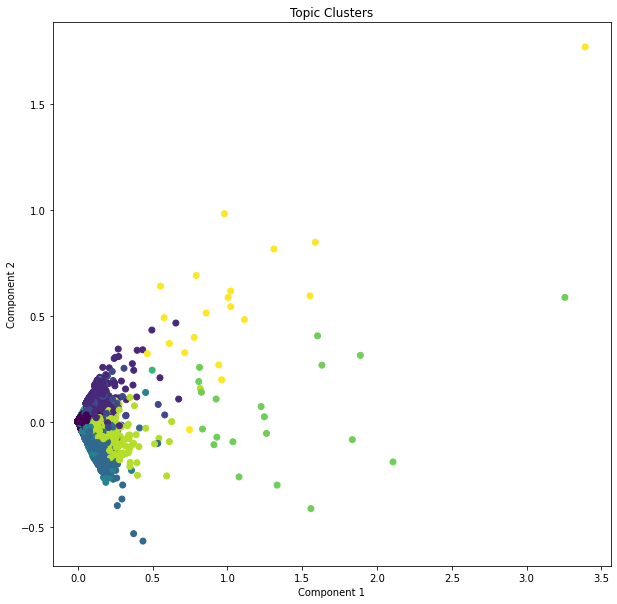

In [46]:
# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")

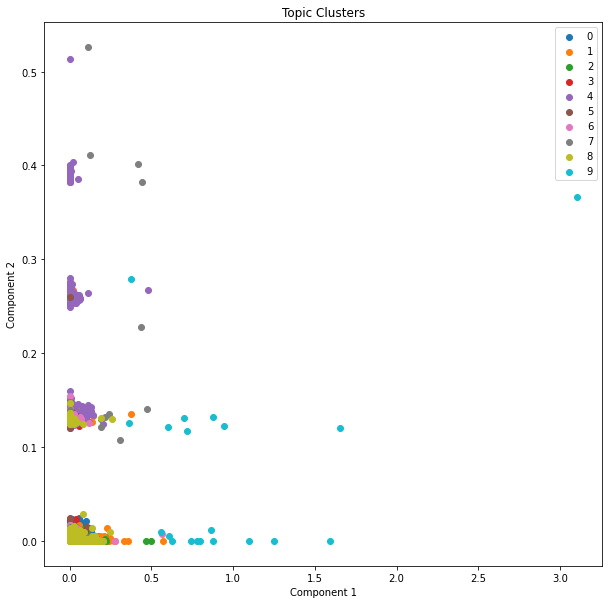

In [47]:
# Plot the cluster of points by topics

k_clusters = np.unique(kmeans_clust)
plt.figure(figsize=(10, 10))
for i in k_clusters:
    filtered_label = output[kmeans_clust == i]
    plt.scatter(filtered_label[:,0], filtered_label[:,1], label = i)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")
plt.legend();

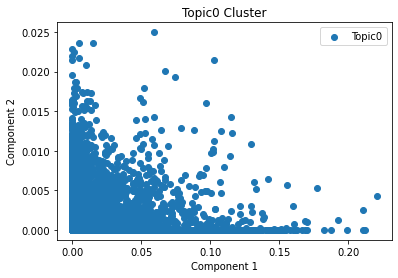

In [48]:
# Topic0 Cluster

filtered_label0 = output[kmeans_clust == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], label = "Topic0")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic0 Cluster")
plt.legend();

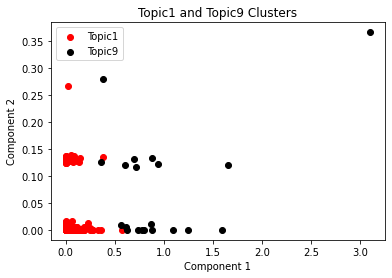

In [49]:
# Topic0 and Topic 1 Clusters
filtered_label1 = output[kmeans_clust == 1]
 
filtered_label9 = output[kmeans_clust == 9]
 
#Plotting the results
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red', label = "Topic1")
plt.scatter(filtered_label9[:,0] , filtered_label9[:,1] , color = 'black', label = "Topic9")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic1 and Topic9 Clusters")
plt.legend();

### Find documents within a topic that are similar to a given document

In [50]:
# Using Euclidean distance

text_example = ["We need food and medical suppies. The kids also need blankets and clothing"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
#print(topic)
print(infer_topic)
doc_ids, docs = similar_corpus(text=text_example, doc_topic_probs=output, documents = message_data, top_n=1, verbose=False)
print('\n', docs[0][:500])
print()

Topic 3

 i don t need food what i need is a tarpaulin for my baby 



### Plots

In [51]:
# Plot distributions
tmp_words = []
for i in range(len(message_words)):
    tmp_words.append(len(message_words[i]))

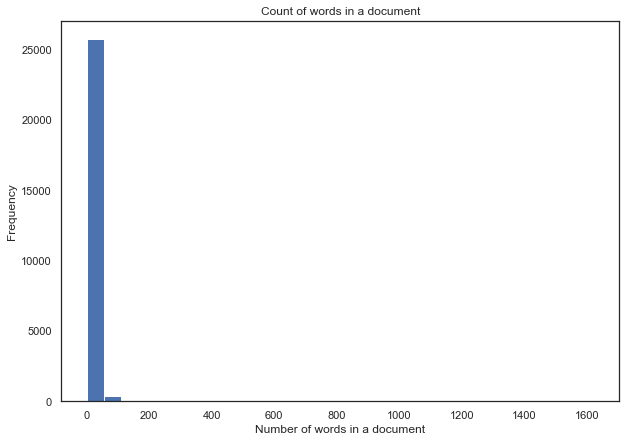

In [52]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(tmp_words,30);
ax.set_title('Count of words in a document')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of words in a document');

In [53]:
# Plots number of documents in topic

topic_list = []
topic_count = []
tot_topic = len(Topics)
for i in range(tot_topic):
    topic_l = Topics[i]
    mask = document_topic_df['dominant_topic'] == i
    topic_c = len(document_topic_df[mask])
    topic_list.append(topic_l)
    topic_count.append(topic_c)

topic_count_dict = {'Topic': topic_list, 'Count': topic_count}
topic_count_df = pd.DataFrame(topic_count_dict)
topic_count_df2 = topic_count_df.sort_values('Count', ascending = False)

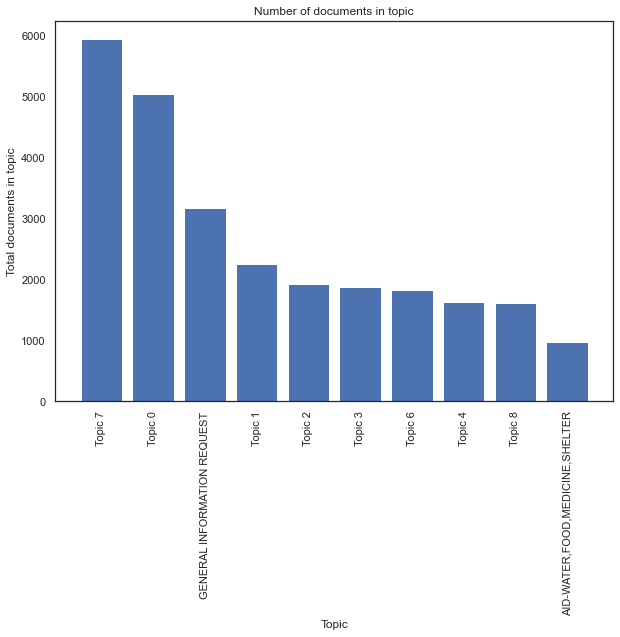

In [54]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
x_index = np.arange(topic_count_df2.Topic.count())
ax.set_xticks(ticks=x_index)

ax.bar(x_index,topic_count_df2['Count']);
ax.set_title('Number of documents in topic')
ax.set_ylabel('Total documents in topic')
ax.set_xlabel('Topic');
ax.set_xticklabels(topic_count_df2['Topic'],rotation = 90, horizontalalignment = 'center' );

### Frequency of keywords in topic

In [55]:
def flatten(outer_list):
    '''
    Function to flatten a list of list
    '''
    return [item for sublist in outer_list for item in sublist]

In [56]:
# top keywords count for Topic 0

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 0
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 0']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

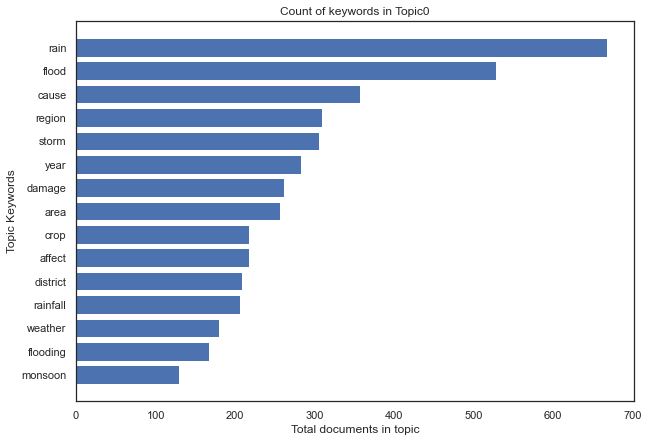

In [57]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic0')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [58]:
# top keywords count for Topic 4

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 4
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 4']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

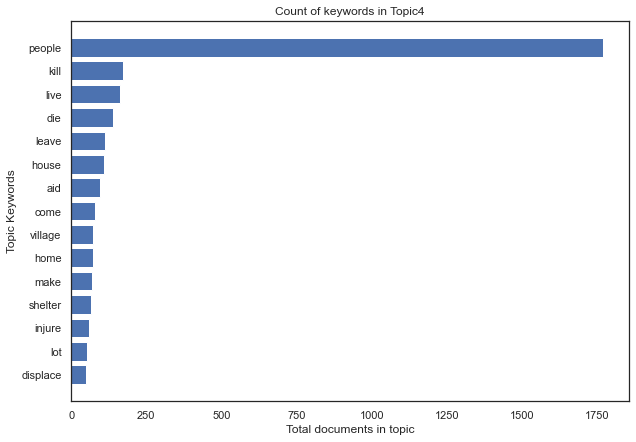

In [59]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic4')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [60]:
# top keywords count for Topic 9

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 9
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 9']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

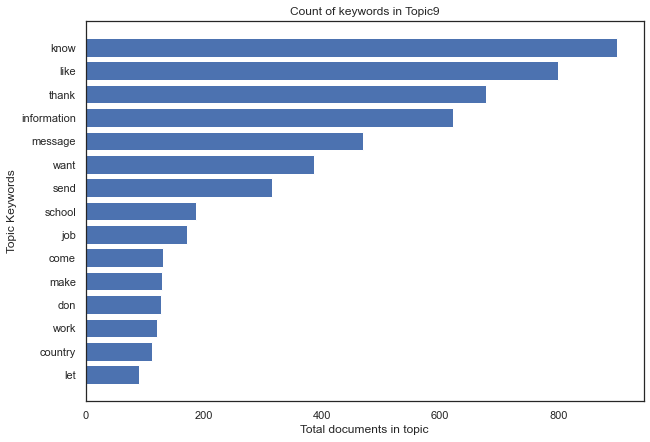

In [61]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic9')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');